# Data Cleaning

In [1]:
# Dependencies
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Read the data from the data folder
df = pd.read_csv('data/ign.csv')

# Selecting what matters
df = df[['score_phrase', 'title']]

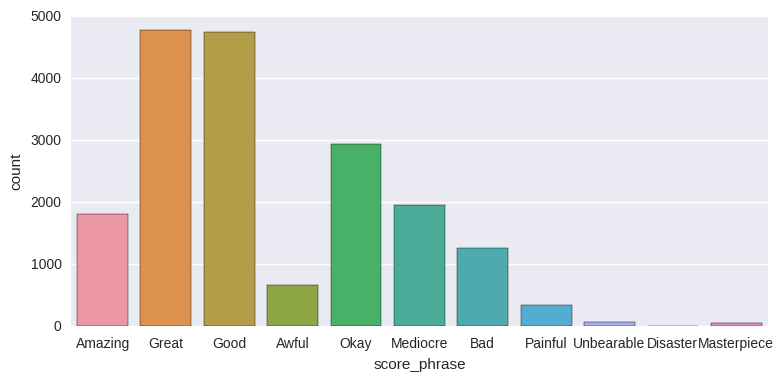

In [3]:
# Plot the distribuiton of categories

# Adjusting size
dims = (9, 4)
fig, ax = plt.subplots(figsize=dims)

# Plotting
sns.countplot(x='score_phrase', data=df)

In [4]:
# Statistics
df.describe(include=['object', 'category'])

,score_phrase,title
count,18625,18625
unique,11,12589
top,Great,Open Season
freq,4773,10


In [5]:
# This function clusterizes different categories into 2 classes: 0 - negative, 1 - positive
def binarization(category):
    positive = ['Amazing', 'Great', 'Good', 'Okay', 'Masterpiece']
    negative = ['Awful', 'Mediocre', 'Bad', 'Painful', 'Unbearable', 'Disaster']
    
    if category in positive:
        category = 1
    
    if category in negative:
        category = 0
    
    return category

positive = ['Amazing', 'Great', 'Good', 'Okay', 'Masterpiece']
negative = ['Awful', 'Mediocre', 'Bad', 'Painful', 'Unbearable', 'Disaster']
categories = positive + negative
categories_dict = CountVectorizer(stop_words=None, lowercase=False).fit(categories).vocabulary_
print "Vocabulary is", categories_dict

# Classes to numbers
def category_to_number(category):
    return categories_dict[category]
    
    

Vocabulary is {u'Unbearable': 10, u'Great': 5, u'Good': 4, u'Okay': 8, u'Disaster': 3, u'Amazing': 0, u'Bad': 2, u'Masterpiece': 6, u'Awful': 1, u'Mediocre': 7, u'Painful': 9}


In [6]:
# Create a new column with the binarized categories
df['binarized'] = df['score_phrase'].apply(binarization)

# Create a new column with numbers representing categories
df['numbers'] = df['score_phrase'].apply(category_to_number)


In [7]:
# Check out data
df.head()

,score_phrase,title,binarized,numbers
0,Amazing,LittleBigPlanet PS Vita,1,0
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,1,0
2,Great,Splice: Tree of Life,1,5
3,Great,NHL 13,1,5
4,Great,NHL 13,1,5


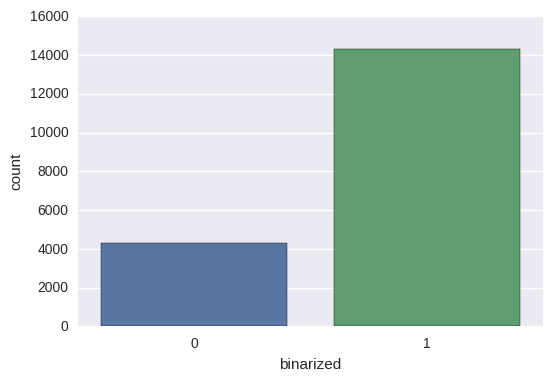

In [8]:
# Check the binarized distribution. Classes are unbalanced!
sns.countplot(x='binarized', data=df)

In [9]:
# This function cleans the data and replace numbers by a common token: NUM. This function is inspired in kim's work
# at https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py

def clean_str(string):
    """
    Tokenization/string cleaning.
    """
    string = re.sub(r"[^A-Za-z0-9(),:!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r":", " : ", string)
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    string = string.strip().lower()
    string = re.sub(r"[0-9]{2,}", "NUM", string)
    return string


In [10]:
# Apply the function to the title column

df['cleaned'] = df['title'].apply(clean_str)

In [11]:
# Take a look at the last 5
df.head()

,score_phrase,title,binarized,numbers,cleaned
0,Amazing,LittleBigPlanet PS Vita,1,0,littlebigplanet ps vita
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,1,0,littlebigplanet ps vita marvel super hero edition
2,Great,Splice: Tree of Life,1,5,splice : tree of life
3,Great,NHL 13,1,5,nhl NUM
4,Great,NHL 13,1,5,nhl NUM


In [12]:
# Instantiate an CountVectorizer object removing english stop words. Set lowercase false cause I've have done this
# and I wanna keep NUM token in uppercase.
vectorizer = CountVectorizer(stop_words='english', lowercase=False)

# Fit the data 
titles_vectorized = vectorizer.fit(df['cleaned'])

# Get the vocabulary
vocabulary = titles_vectorized.vocabulary_

words = set(vocabulary.keys())

# Size of vocabulary
size_vocab = len(vocabulary)
print "The vocabulary has {} words".format(size_vocab)

# Get the data cleaned and transform words in numerical tokens.
text = df['cleaned'].tolist()
text = [string.split() for string in text]
# tokens is a list of lists. Each list inside tokens represents a sentence
tokens = []
for sentence in text:
    dummy = []
    for word in sentence:
        if word in words:
            dummy.append(vocabulary[word] + 1) # Sum 1 cause I want to leave the token 0 for padding in LSTM.
    tokens.append(dummy)
    
# Maximum length of a sentence in the data
max_len = max([len(sentence) for sentence in tokens])
print "The largest sentence has {} tokens".format(max_len)

The vocabulary has 7572 words
The largest sentence has 14 tokens


In [13]:
# Gather info

# Sentences
X = tokens

# binary labels
y_2 = df['binarized']

# All 11 classes
y_11 = df['numbers']

# Vocabulary size
size_vocab

# Maximum length
max_len

14

In [14]:
# Let's split the data in training, validation and test
# First split data into train and dummy
X_train, X_dummy, y_2_train, y_2_dummy = train_test_split(X, y_2, train_size=0.6, random_state=7)

# Now split dummy into validation and test
X_validation, X_test, y_2_validation, y_2_test = train_test_split(X_dummy, y_2_dummy, test_size=0.5,\
                                                                  random_state=7)

# Same procedure using all 11 labels
X_train, X_dummy, y_11_train, y_11_dummy = train_test_split(X, y_11, train_size=0.6, random_state=7)

# Now split dummy into validation and test
X_validation, X_test, y_11_validation, y_11_test = train_test_split(X_dummy, y_11_dummy, test_size=0.5,\
                                                                  random_state=7)




# Deep Learning Time

# First using LSTM and 2 labels

In [15]:
# Dependencies
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences

In [16]:
# Sequence padding
trainX = pad_sequences(X_train, maxlen=max_len, value=0.) # max_len was found some cells above
validationX = pad_sequences(X_validation, maxlen=max_len, value=0.)
testX = pad_sequences(X_test, maxlen=max_len, value=0.)

# Converting labels to binary vectors
trainY_2 = to_categorical(y_2_train, nb_classes=2)
validationY_2 = to_categorical(y_2_validation, nb_classes=2)
testY_2 = to_categorical(y_2_test, nb_classes=2)


In [17]:
# Network building
net = tflearn.input_data([None, max_len])
net = tflearn.embedding(net, input_dim=size_vocab + 1, output_dim=128) # input_dim is size_vocab + 1 cause now we
                                                                        # have a 0 token. 
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.0001,
                         loss='categorical_crossentropy')


In [18]:
# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY_2, validation_set=(validationX, validationY_2), show_metric=True,
          batch_size=32, n_epoch = 10)


Training Step: 3500  | total loss: 0.21728
| Adam | epoch: 010 | loss: 0.21728 - acc: 0.9151 | val_loss: 0.57073 - val_acc: 0.7793 -- iter: 11175/11175
Training Step: 3500  | total loss: 0.21728
| Adam | epoch: 010 | loss: 0.21728 - acc: 0.9151 | val_loss: 0.57073 - val_acc: 0.7793 -- iter: 11175/11175
--


In [30]:
# Get the predictions -- List of list of probabilities
y_pred_2 = model.predict(testX)

# Get the list of classes
y_pred_2 = np.array(y_pred_2)
y_pred_2 = np.argmax(y_pred_2, axis=1).tolist()

print y_pred_2[:10]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
# The classes are unbalanced. So accuracy is not a good metric for the problem. Let's use the confusion matrix and 
# and a classification report
from sklearn.metrics import confusion_matrix, classification_report

In [38]:
# Classfication report
print classification_report(y_2_test, y_pred_2)

             precision    recall  f1-score   support

          0       0.51      0.41      0.46       852
          1       0.83      0.88      0.86      2873

avg / total       0.76      0.77      0.77      3725



In [35]:
# Confusion matrix
cm = confusion_matrix(y_2_test, y_pred_2, labels=[1,0])

print cm

[[2535  338]
 [ 501  351]]


In [25]:
# This function helps us to plot a fancy confusion matrix. It takes the confusion matrix as inpunt!

def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues, rotation=False):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    bal = classes
    tick_marks = np.arange(len(bal))
    if rotation:
        plt.xticks(tick_marks, bal, rotation=60)
    else:
        plt.xticks(tick_marks, bal)
    plt.yticks(tick_marks, bal)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


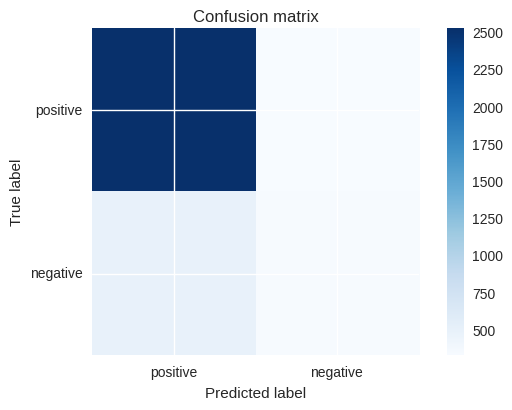

In [34]:
plot_confusion_matrix(cm, ['positive', 'negative'])

# Let's use CNN and 2 classes

In [19]:
# Dependencies
from tflearn.layers.conv import conv_1d, global_max_pool
from tflearn.layers.merge_ops import merge
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

Training Step: 3500  | total loss: 0.19644
| Adam | epoch: 010 | loss: 0.19644 - acc: 0.9250 | val_loss: 0.70534 - val_acc: 0.7729 -- iter: 11175/11175
Training Step: 3500  | total loss: 0.19644
| Adam | epoch: 010 | loss: 0.19644 - acc: 0.9250 | val_loss: 0.70534 - val_acc: 0.7729 -- iter: 11175/11175
--
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
             precision    recall  f1-score   support

          0       0.48      0.42      0.45       852
          1       0.83      0.86      0.85      2873

avg / total       0.75      0.76      0.76      3725

[[2484  389]
 [ 495  357]]


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


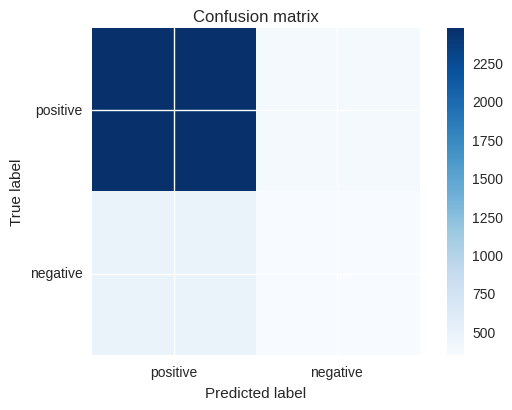

In [20]:
# Network building
network = tflearn.input_data([None, max_len])
network = tflearn.embedding(network, input_dim=size_vocab + 1, output_dim=128) # input_dim is size_vocab + 1 cause now we
                                                                        # have a 0 token. 
branch1 = conv_1d(network, 128, 3, padding='valid', activation='relu', regularizer="L2")
branch2 = conv_1d(network, 128, 4, padding='valid', activation='relu', regularizer="L2")
branch3 = conv_1d(network, 128, 5, padding='valid', activation='relu', regularizer="L2")
network = merge([branch1, branch2, branch3], mode='concat', axis=1)
network = tf.expand_dims(network, 2)
network = global_max_pool(network)
network = dropout(network, 0.5)
network = fully_connected(network, 2, activation='softmax')
network = regression(network, optimizer='adam', learning_rate=0.001,
                     loss='categorical_crossentropy', name='target')

# Training
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit(trainX, trainY_2, validation_set=(validationX, validationY_2), show_metric=True,
          batch_size=32, n_epoch = 10)


# Get the predictions -- List of list of probabilities
y_pred_2cnn = model.predict(testX)

# Get the list of classes
y_pred_2cnn = np.array(y_pred_2cnn)
y_pred_2cnn = np.argmax(y_pred_2cnn, axis=1).tolist()

print y_pred_2cnn[:10]

# Classfication report
print classification_report(y_2_test, y_pred_2cnn)

# Confusion matrix
cm = confusion_matrix(y_2_test, y_pred_2cnn, labels=[1,0])

print cm

plot_confusion_matrix(cm, ['positive', 'negative'])


# LSTM and 11 classes

In [20]:
# Converting labels to binary vectors
trainY_11 = to_categorical(y_11_train, nb_classes=11)
validationY_11 = to_categorical(y_11_validation, nb_classes=11)
testY_11 = to_categorical(y_11_test, nb_classes=11)

# Network building
net = tflearn.input_data([None, max_len])
net = tflearn.embedding(net, input_dim=size_vocab + 1, output_dim=128) # input_dim is size_vocab + 1 cause now we
                                                                        # have a 0 token. 
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, 11, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.0001,
                         loss='categorical_crossentropy')


# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY_11, validation_set=(validationX, validationY_11), show_metric=True,
          batch_size=32, n_epoch = 10)


Training Step: 3500  | total loss: 1.50534
| Adam | epoch: 010 | loss: 1.50534 - acc: 0.3933 | val_loss: 1.90316 - val_acc: 0.2617 -- iter: 11175/11175
Training Step: 3500  | total loss: 1.50534
| Adam | epoch: 010 | loss: 1.50534 - acc: 0.3933 | val_loss: 1.90316 - val_acc: 0.2617 -- iter: 11175/11175
--


             precision    recall  f1-score   support

          0       0.00      0.00      0.00       348
          1       0.00      0.00      0.00       132
          2       0.15      0.12      0.13       247
          3       0.00      0.00      0.00         2
          4       0.28      0.22      0.25       956
          5       0.37      0.42      0.39       956
          6       0.00      0.00      0.00        16
          7       0.21      0.27      0.24       380
          8       0.22      0.44      0.29       597
          9       0.00      0.00      0.00        72
         10       0.00      0.00      0.00        19

avg / total       0.23      0.27      0.24      3725



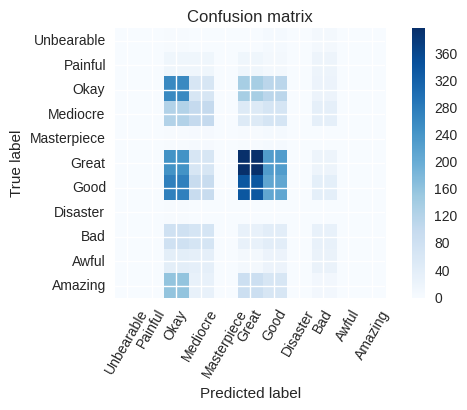

In [26]:
# Get the predictions -- List of list of probabilities
y_pred_11 = model.predict(testX)

# Get the list of classes
y_pred_11 = np.array(y_pred_11)
y_pred_11 = np.argmax(y_pred_11, axis=1).tolist()

# Classfication report
print classification_report(y_11_test, y_pred_11)

# Confusion matrix
cm = confusion_matrix(y_11_test, y_pred_11, labels=[10,9,8,7,6,5,4,3,2,1,0])

plot_confusion_matrix(cm, ['Unbearable', 'Painful', 'Okay', 'Mediocre', 'Masterpiece', \
                           'Great', 'Good', 'Disaster', 'Bad', 'Awful', 'Amazing'], rotation=True)